**Authors:**
Jonas Juhler-Nøttrup (S164217), Niels Asp Fuglsang (S164181), Morten Wehlast Jørgensen (S147056), Jens Thuren Lindahl (S124347)

## 42186 Model-based Machine Learning - Bayesian Spatial Count

Research topic: How may we model non-linear dependencies on the inputs $\textbf{X}_n$?

More specifically, we wish to determine the advantages and disadvantages of the following approaches:
- Neural network 
- Hierarchical modelling

For each area $n$ in data set, we observe a count of injuries, $y_n$. 
The normal apprach is to assume linear dependence such that
$$
y_n \sim \text{NB}(r, p_n) \\
p_n= \frac{\exp(\psi_n)}{1+\exp(\psi_n)} \\
\psi_n = \beta^T\textbf{X}_n+\phi_n
$$

Where $\textbf{X}_n$ are the characteristics of the area and $\phi_n$ is a correlated error term with mean 0 and standard deviation $\sigma$.

### Neural Network

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now split the characteristics into a set of inputs for our linear term, $\textbf{X}'_n$ and a set of inputs for our non-linear term, $\textbf{X}^*_n$, such that
$$
\psi_n = \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

#### PGM
![image info](./neural_net_pgm.jpg)


#### Generative Process

<ol>
    <li> Set hyperparameter $r$. </li>
    <li> Set hyperparameter $\sigma$. </li>
    <li> Draw linear coefficients $\beta \sim N(\beta|\textbf{0},\lambda \textbf{I})$</li>
    <li> Draw non-linear coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

### Hierarchical model
In the hierarchical model we follow the normal approach outlined in the beginning with an added hierarchical layer. By inspection of the data, we see that groupings can be made based on feature `County`. This means that we can fit $k$ sets of coefficients given by $(\beta_1, \beta_2, \dots, \beta_k)$, where $\beta_i$ denote the coefficients associated with county $i$. Similarly, we introduce a shared global prior, that prevents overfitting by reducing the flexibility of the model. If we let $k_n$ denote the group that the n'th observation belongs to then the only modification to the normal approach is that we compute $\psi_n$ based on $\beta_{k_n}$.

$$
\psi_n = \beta_{k_n}^T\textbf{X}_n+\phi_n
$$

#### PGM
![image info](./hierarchical.jpg)

#### Generative Process
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(1)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\textbf{0},\lambda\textbf{I})$</li>
    </ol>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>


## Data
https://figshare.com/articles/dataset/Data_for_Bayesian_Hierarchical_Spatial_Models_nmplementing_the_Besag_York_Molli_Model_nn_Stan/9729149/1

https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf

In [1]:
# Load packages
import pandas as pd
from matplotlib import pyplot as plt

## Data description
The data set consists of 7 features
 - `census_tract` ID for the census/region. Nominal, integer.
 - `ped_nnjury_5to18` Number of injuries for pedestrians aged 5-18 in the years 2005-2014. Ratio, integer.
 - `youth_pop_5to18` Population of youths aged aged 5-18 within the census/region in 2010. Ratio, integer.
 - `commute_priv_vehicle` Percentage commuters who traveled to work primarily by a private vehicle, from the American Community Survey for the years 2010-2014. Ration, continuous.
 - `med_hhincome` Median household income from American Community Survey for the years 2010-2014. Interval, integer.
 - `avg_ann_daily_traffic` Maximum value of street-level annual average daily traffic values for that census tract from 2015. Interval, integer.
 - `fragment_nndex` A combined metric consisting of standardized data describing; estimates of vacant housing units, householders living alone, non-owner occupied housing units and population having moved within the previous year. Interval, continuous.
 
 
The project will treat `ped_nnjury_5to18` as the dependent variable $y$. 

First, we will look at some descriptive statistics for all non-nominal features.<br>
Next, we visualize them to get a better understanding of their distributions.

## Descriptive Statistics

In [2]:
nominals = ["census_tract"]
df = pd.read_csv("data/bym_nyc_study.csv")
df_nn = df[df.columns[~df.columns.isin(nominals)]] # Select all non-nominals for description
df_nn.describe() # Select all non-nominals for description

,ped_injury_5to18,youth_pop_5to18,commute_priv_vehicle,med_hhincome,avg_ann_daily_traffic,fragment_index
count,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2.095000e+03
mean,8.206683,596.447255,0.302574,58496.796181,37247.564932,-3.818519e-12
std,7.454526,370.046583,0.191031,28567.156059,43316.943386,2.677234e+00
min,0.000000,6.000000,0.000000,9327.000000,843.000000,-6.728742e+00
25%,3.000000,326.000000,0.145954,38624.000000,12341.000000,-1.818569e+00
50%,6.000000,510.000000,0.260870,53882.000000,19178.000000,-1.085420e-01
75%,11.500000,789.500000,0.439009,72928.500000,37201.000000,1.436548e+00
max,57.000000,3315.000000,0.902256,232266.000000,276476.000000,1.867200e+01


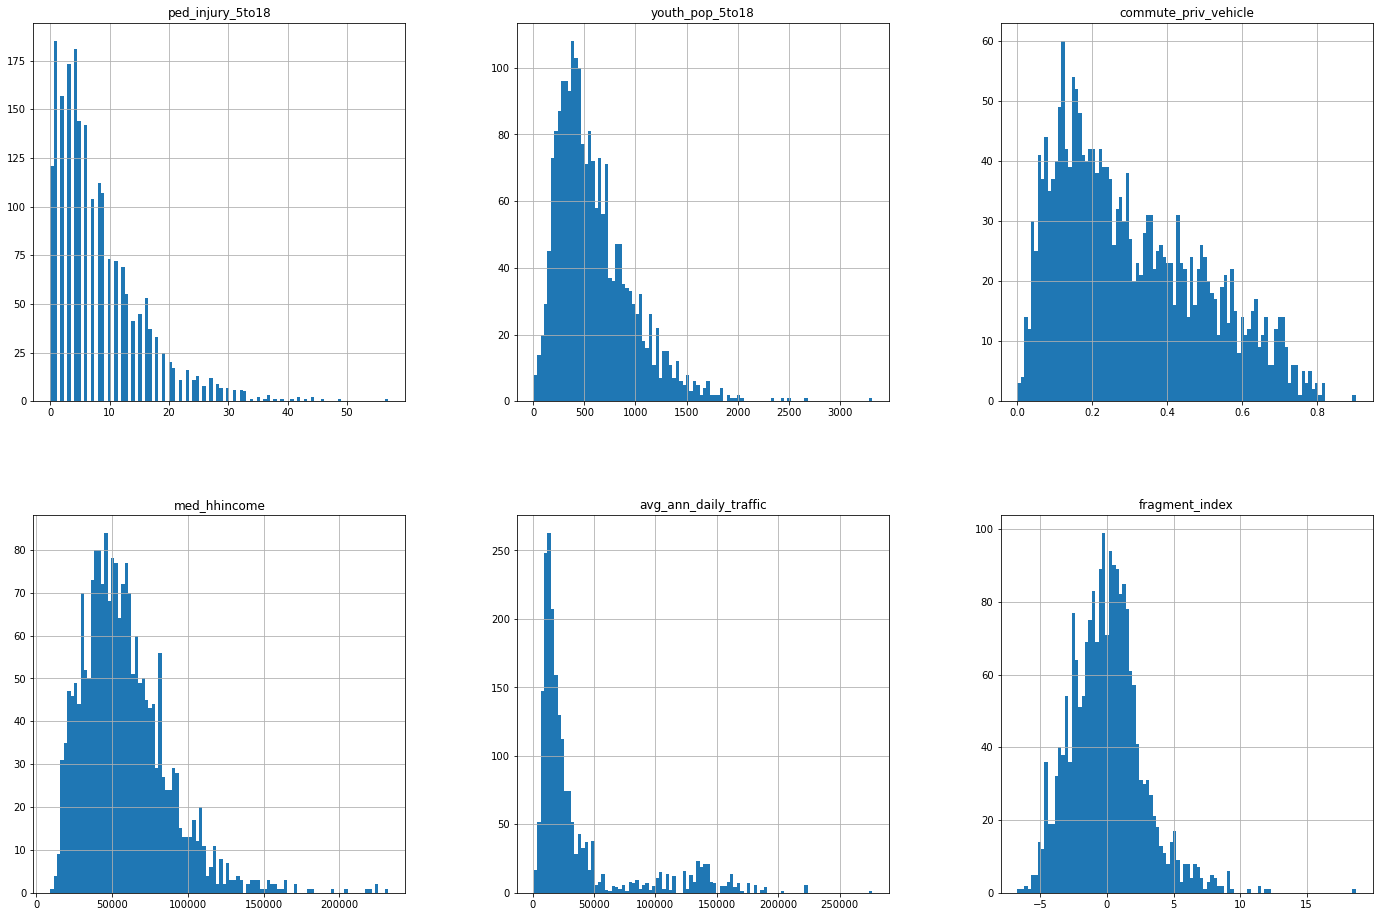

In [3]:
fig, axes = plt.subplots(len(df_nn.columns)//3, 3, figsize=(24, 16))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_nn.hist(column = df_nn.columns[i], bins = 100, ax=axis)
        i = i+1

In [4]:
df_census = pd.read_csv("data/nyc_census_tracts.csv")
merged_df = df.merge(df_census, how="left", left_on="census_tract", right_on="CensusTract")

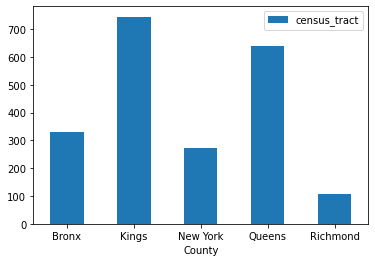

In [5]:
fig, ax = plt.subplots(1,1)
merged_df.groupby("County").count().plot.bar(y="census_tract", ax=ax, rot=0)
plt.show()